In [21]:
import librosa
import librosa.display
from matplotlib import pyplot as plt

from IPython.display import Audio
%matplotlib inline

# Intro to audio

What is sound?

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S3_Waveform.html

Ok, let's inspect a sound.

In [14]:
filename = librosa.util.example_audio_file()
y, sr = librosa.core.load(filename)

In [24]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [25]:
y.shape

(1355168,)

In [26]:
sr

22050

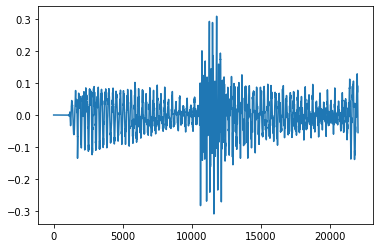

In [22]:
plt.plot(y[:sr])

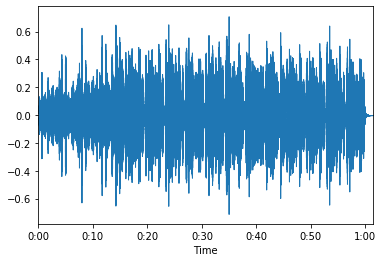

In [8]:
librosa.display.waveplot(y, sr)

In [27]:
Audio(data=y, rate=sr)